# Test of Various Data Obfuscation Methods

In this section of the study, our approach involves systematically eliminating or concealing samples originating from individual tenements. This process is applied across all tenements under consideration. The primary objective is to observe the resultant effects on the utility loss, which is closely linked to the manner in which samples are modified within specific tenements.

In [1]:
# Import necessary libraries
import shapely
import warnings
import os
import numpy as np
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

# Suppress ShapelyDeprecationWarning and numpy warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
np.warnings.filterwarnings('ignore')

import sys

# Append the parent directory to the system path
sys.path.append('..')

# Import functions and modules from the local 'minerals' package
from minerals import *

# Define the path and side length
path = '..'
side_len = 50

# Define a list of 'l' values
l = [5, 10]

# Define directories for output files based on 'l' values
directory1 = path + '/data_' + str(side_len) + '/out_l=' + str(l)
directory2 = path + '/data_' + str(side_len) + '/out_inner_l=' + str(l)

# Create the directories if they don't exist
for directory in [directory1, directory2]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Read files and store them in a DataFrame
df = read_files(path)

# Read CSV data into a DataFrame for df_minerals_grid
df_minerals_grid = pd.read_csv('../data/df_minerals_grid_' + str(side_len) + '_v2.csv')

#connect grid to tenement df_sample
df_sampling_tenement =  pd.read_csv('../data/df_sampling_tenement_'+str(side_len)+'_v2.csv')

# Create a DataFrame to store the counts of TENID values
df_counts = pd.DataFrame(df_sampling_tenement['TENID'].value_counts())

# Convert 'tenements_final' column values to lists
df_minerals_grid['tenements_final'] = [eval(x) for x in df_minerals_grid['tenements']]

# Define a list of specific tenement IDs
list_tens = ['E  7702143', 'E  7702188', 'E  7702219', 'E  7702220', 'E  7702239', 'E  7702349', 'E  7702472', 'E  7702837',
               'E  7702840', 'L  7700292', 'P  7704290', 'P  7704325',
               'P  7704326', 'P  7704590', 'P  7704591', 'P  7704592']

# Get all unique tenement IDs from the DataFrame
list_tens_all = df_minerals_grid['tenements_final'].tolist()

# Create a flat list of tenement IDs that are not in 'list_tens'
flat_list = (set([item for sublist in list_tens_all for item in sublist])) - set(list_tens)

# Iterate through the rows of df_minerals_grid DataFrame
for id, row in df_minerals_grid.iterrows():
    ll = row.tenements_final
    
    # Remove tenements in 'flat_list' from the list
    for ten in row.tenements_final:
        if ten in flat_list:
            ll.remove(ten)
    
    # Update 'tenements_final' based on specific conditions
    if len(ll) == 0:
        df_minerals_grid.loc[df_minerals_grid.index == id, 'tenements_final'] = ''
    elif len(ll) > 1:
        val = df_counts.loc[ll].sort_values(by='TENID').tail(1).index[0]
        df_minerals_grid.loc[df_minerals_grid.index == id, 'tenements_final'] = val
    else:
        df_minerals_grid.loc[df_minerals_grid.index == id, 'tenements_final'] = ll[0]

# Update 'tenements' column with 'tenements_final'
df_minerals_grid['tenements'] = df_minerals_grid['tenements_final']


This section of code is aiming to analyze the impact of sample removal on prospectivity calculations. It includes 
* recalculate prospectivity probability after removing a tenement's samples, 
* recalculate prospectivity probability after removing a interiro tenement's samples,
* recalculating confidence loss and the mean absolute errors


In [ ]:
# Sort the DataFrame by 'coords_x' and 'coords_y' columns
df_minerals_grid = df_minerals_grid.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)

# Create a new column for original prospectivity probabilities
df_minerals_grid['proba_prospectivity_orig-40'] = df_minerals_grid['proba_prospectivity-40']

# Initialize a new column for absolute error
df_minerals_grid['abs_error_orig'] = 0



# Initialize dictionaries for tenement and inner cell information
ten_dico, inner_dico = {}, {}

# Iterate through each tenement ID in the list
for tenement_id in list_tens:
    # Get a list of cells, their borders, and inner cells related to the current tenement
    list_cells_of, cellsborders, innercells = getboder_cells(df_minerals_grid, tenement_id)

    # Get a list of samples within the current tenement's cells
    list_sampl_into_tenement = df_sampling_tenement[df_sampling_tenement.cell.isin(list_cells_of)]['sample'].tolist()

    # Check if there are samples within the tenement
    if len(list_sampl_into_tenement) > 0:
        # Calculate the fraction of confidence loss for the entire dataset
        conf_loss_count = (len(df_sampling_tenement) - len(list_sampl_into_tenement)) / len(df_sampling_tenement)

        # Calculate the fraction of confidence loss within the current tenement
        conf_loss_tnmt_count = 0

        # Remove samples from the current tenement and recalculate prospectivity
        df_trn = remove_and_recalculate_prospectivy(df, df_minerals_grid, tenement_id, directory1, list_sampl_into_tenement)
        df_trn = df_trn.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)

        # Calculate the absolute error for the current tenement's prospectivity
        df_trn['abs_error_' + tenement_id.replace(' ', '')] = (df_trn['proba_prospectivity_orig-40'] - df_trn['proba_prospectivity-40']).abs()

        # Rename columns for the current tenement's prospectivity
        df_trn = df_trn.rename(columns={'proba_prospectivity_orig-40': 'proba_prospectivity_orig', 'proba_prospectivity-40': 'proba_prospectivity_' + tenement_id.replace(' ', '')})

        # Get a list of samples within the inner cells of the current tenement
        list_sampl_inner_tenement = df_sampling_tenement[df_sampling_tenement.cell.isin(innercells)]['sample'].tolist()

        # Calculate the fraction of confidence loss for the inner cells
        conf_loss_count2 = (len(df_sampling_tenement) - len(list_sampl_inner_tenement)) / len(df_sampling_tenement)

        # Calculate the fraction of confidence loss within the inner cells of the current tenement
        conf_loss_tnmt_count2 = (len(list_sampl_into_tenement) - len(list_sampl_inner_tenement)) / len(list_sampl_into_tenement)

        # Remove samples from the inner cells of the current tenement and recalculate prospectivity
        df_trn_inner = remove_and_recalculate_prospectivy(df, df_minerals_grid, tenement_id, directory2, list_sampl_inner_tenement)
        df_trn_inner = df_trn_inner.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)

        # Calculate the absolute error for the inner cells of the current tenement's prospectivity
        df_trn_inner['abs_error_' + tenement_id.replace(' ', '')] = (df_trn_inner['proba_prospectivity_orig-40'] - df_trn_inner['proba_prospectivity-40']).abs()

        # Rename columns for the inner cells of the current tenement's prospectivity
        df_trn_inner = df_trn_inner.rename(columns={'proba_prospectivity_orig-40': 'proba_prospectivity_orig', 'proba_prospectivity-40': 'proba_prospectivity_' + tenement_id.replace(' ', '')})


## Figure 7: Utility loss measured as top-5 mean absolute error of hiding various tenements.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

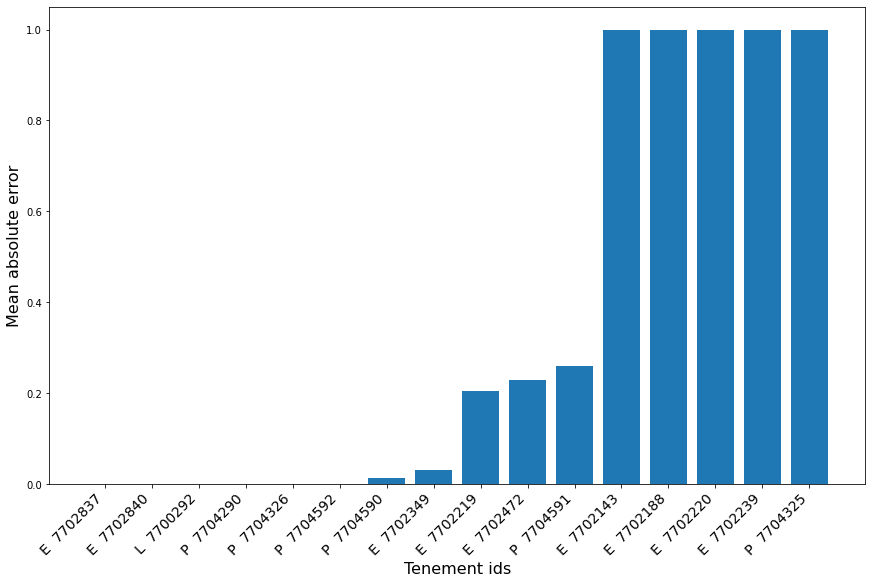

In [10]:
# Set the value of 'l' to 20
l = 5

# Create an empty DataFrame to store mean errors
meanerrs = pd.DataFrame()

# Iterate through a list of tenement IDs
for tenement_id in ['E  7702143', 'E  7702188', 'E  7702219', 'E  7702220', 'E  7702239', 'E  7702349', 'E  7702472', 'E  7702837', 'E  7702840', 'L  7700292', 'P  7704290', 'P  7704325',
               'P  7704326', 'P  7704590', 'P  7704591', 'P  7704592']:
    
    # Remove spaces from the tenement ID to create a clean identifier
    tenid = tenement_id.replace(' ', '')
    
    # Read CSV data into DataFrame for the current tenement
    df_trn = pd.read_csv(directory1 + '/tenement_no_' + tenement_id.replace(' ', '_') + '.csv')
    
    # Calculate and add the absolute error column for the specific tenement
    df_trn['abs_error_' + tenement_id.replace(' ', '')] = (df_trn['proba_prospectivity_orig-40'] - df_trn['proba_prospectivity-40']).abs()
    
    # Select the k largest errors from the DataFrame for the current tenement
    klargest_errors = df_trn[df_trn.tenements != tenement_id]['abs_error_' + tenid].nlargest(l).values
    
    # Append mean error and tenement ID to the meanerrs DataFrame
    meanerrs = meanerrs.append({'id': tenement_id, 'error': round(np.mean(klargest_errors), 3)}, ignore_index=True)

# Sort the meanerrs DataFrame by error
meanerrs = meanerrs.sort_values(by=['error'])

# Set the figure size
plt.rcParams["figure.figsize"] = (20, 8)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Create a bar chart displaying mean errors for each tenement
plt.bar(meanerrs['id'], meanerrs['error'])
plt.xlabel('Tenement ids', fontsize=16)
plt.ylabel('Mean absolute error', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)


## Figure 8: Utility loss measured as top-20 mean absolute error of hiding various tenements.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

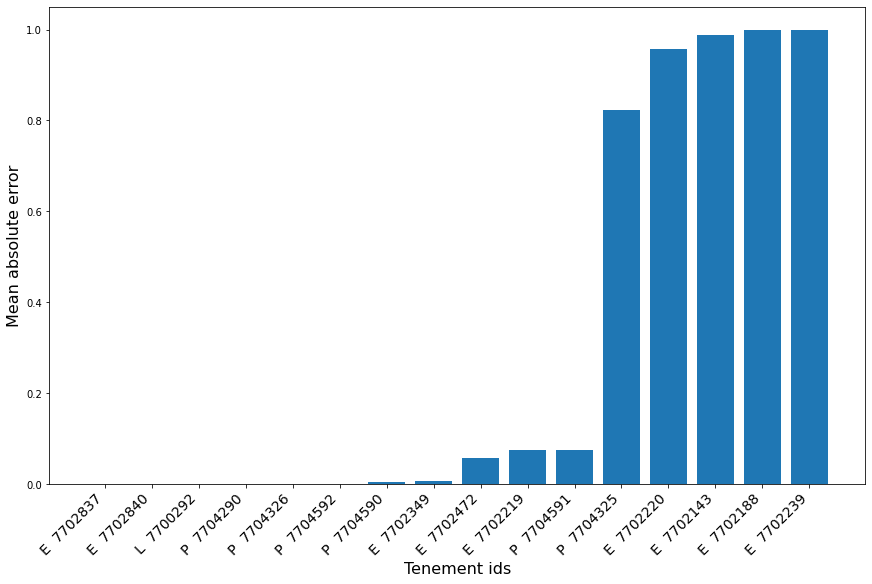

In [9]:
# Set the value of 'l' to 20
l = 20

# Create an empty DataFrame to store mean errors
meanerrs = pd.DataFrame()

# Iterate through a list of tenement IDs
for tenement_id in ['E  7702143', 'E  7702188', 'E  7702219', 'E  7702220', 'E  7702239', 'E  7702349', 'E  7702472', 'E  7702837', 'E  7702840', 'L  7700292', 'P  7704290', 'P  7704325',
               'P  7704326', 'P  7704590', 'P  7704591', 'P  7704592']:
    
    # Remove spaces from the tenement ID to create a clean identifier
    tenid = tenement_id.replace(' ', '')
    
    # Read CSV data into DataFrame for the current tenement
    df_trn = pd.read_csv(directory1 + '/tenement_no_' + tenement_id.replace(' ', '_') + '.csv')
    
    # Calculate and add the absolute error column for the specific tenement
    df_trn['abs_error_' + tenement_id.replace(' ', '')] = (df_trn['proba_prospectivity_orig-40'] - df_trn['proba_prospectivity-40']).abs()
    
    # Select the k largest errors from the DataFrame for the current tenement
    klargest_errors = df_trn[df_trn.tenements != tenement_id]['abs_error_' + tenid].nlargest(l).values
    
    # Append mean error and tenement ID to the meanerrs DataFrame
    meanerrs = meanerrs.append({'id': tenement_id, 'error': round(np.mean(klargest_errors), 3)}, ignore_index=True)

# Sort the meanerrs DataFrame by error
meanerrs = meanerrs.sort_values(by=['error'])

# Set the figure size
plt.rcParams["figure.figsize"] = (20, 8)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

# Create a bar chart displaying mean errors for each tenement
plt.bar(meanerrs['id'], meanerrs['error'])
plt.xlabel('Tenement ids', fontsize=16)
plt.ylabel('Mean absolute error', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)


## Figure 9: Utility loss measured as top-𝐿 mean absolute error (loss_MAE-𝐿) of hiding various tenements against 𝐿.

This code calculates and visualizes the mean absolute errors for different 'l' values (representing the top 'l' errors) associated with various tenements. It involves iterating through different 'l' values and tenement IDs, performing calculations, and generating a bar plot to compare mean errors across tenements and 'l' values.

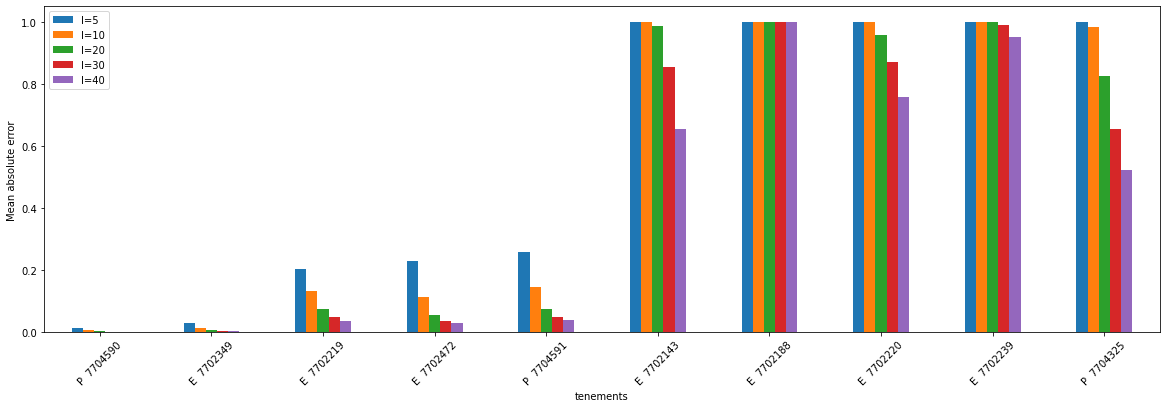

In [6]:
# Initialize an empty DataFrame to store mean errors
meanerrs = pd.DataFrame()

# Iterate through different values of 'l'
for l in [5, 10, 20, 30, 40]:
    # Initialize a temporary DataFrame to store mean errors for the current 'l'
    meanerrs_tmp = pd.DataFrame()
    
    # Iterate through each tenement ID
    for tenement_id in list_tens:
        # Prepare tenement ID for column naming
        tenid = tenement_id.replace(' ', '')
        
        # Read the DataFrame containing prospectivity values for the current tenement
        df_trn = pd.read_csv(directory1 + '/tenement_no_' + tenement_id.replace(' ', '_') + '.csv')
        
        # Calculate the absolute errors and select the top 'l' errors
        df_trn['abs_error_' + tenement_id.replace(' ', '')] = (df_trn['proba_prospectivity_orig-40'] - df_trn['proba_prospectivity-40']).abs()
        klargest_errors = df_trn[df_trn.tenements != (tenement_id)]['abs_error_' + tenid].nlargest(l).values
        
        # Append mean error for the current tenement and 'l' to the temporary DataFrame
        meanerrs_tmp = meanerrs_tmp.append({'id': tenement_id, 'l=' + str(l): round(np.mean(klargest_errors), 3)}, ignore_index=True)
    
    # If 'l' is 5, assign the temporary DataFrame to 'meanerrs'
    if l == 5:
        meanerrs = meanerrs_tmp.copy()
    else:
        # Merge the temporary DataFrame with 'meanerrs' for other 'l' values
        meanerrs = pd.merge(meanerrs, meanerrs_tmp, on="id")

# Filter rows where the sum of mean errors for different 'l' values is greater than 0
meanerrs0 = meanerrs.loc[meanerrs[['l=5', 'l=10', 'l=20', 'l=30', 'l=40']].sum(axis=1) > 0]

# Sort the filtered DataFrame by the mean error for 'l=5'
meanerrs0 = meanerrs0.sort_values(by=['l=5'])

# Create a plot to visualize mean errors for different 'l' values
fig, ax = plt.subplots(figsize=(20, 6))
meanerrs0[['l=' + str(l) for l in [5, 10, 20, 30, 40]]].plot(kind='bar', ax=ax)

# Set labels for axes and tick labels for tenements
ax.set_xlabel('tenements')
ax.set_ylabel('Mean absolute error')
ax.set_xticklabels(meanerrs0.id.tolist(), rotation=45)

# Display the plot
plt.show()


390it [00:29, 13.08it/s]
390it [00:00, 4926.55it/s]
390it [00:30, 13.00it/s]
390it [00:00, 5072.84it/s]


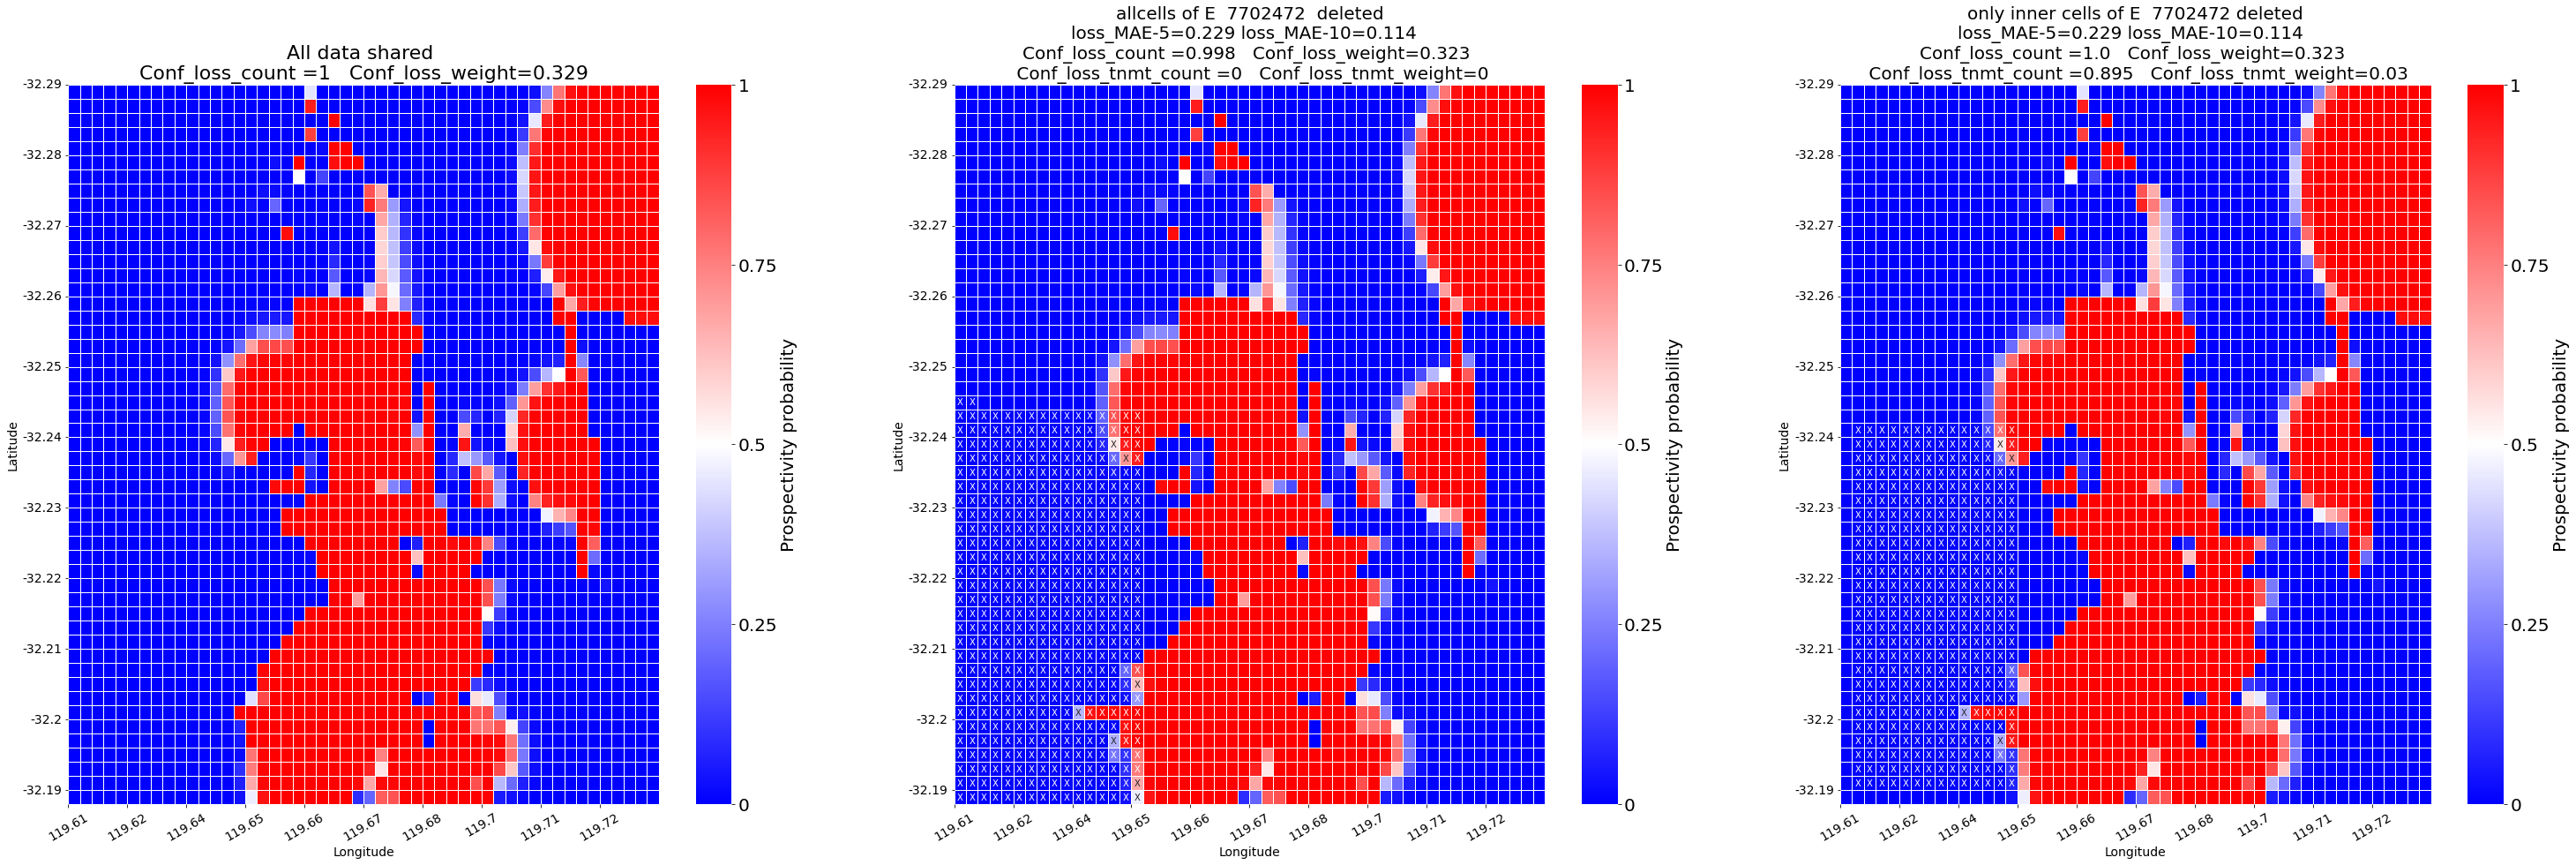

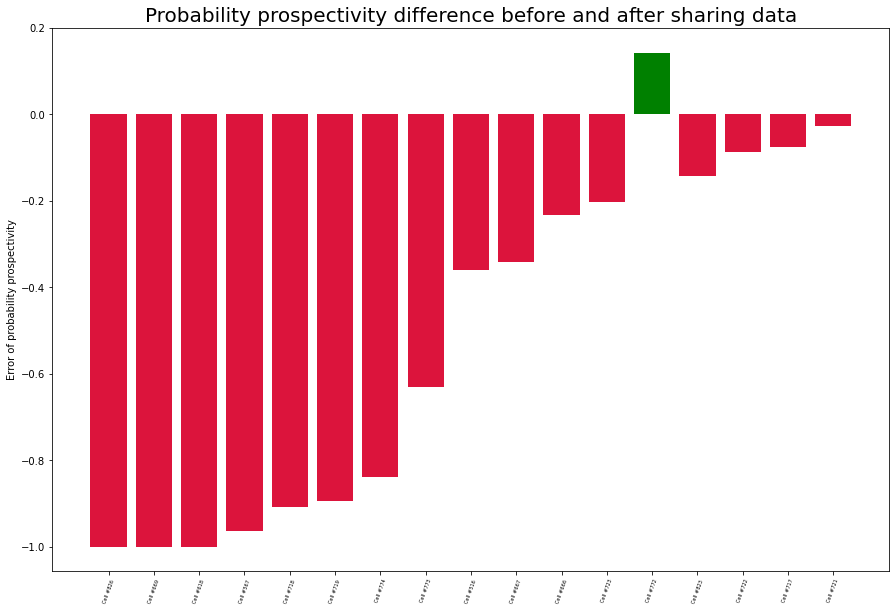

In [16]:

list_tens = ['E  7702472']#, 'E  7702219']

df_minerals_grid = df_minerals_grid.sort_values(by=['coords_x','coords_y'],ignore_index=True)

df_minerals_grid
df_minerals_grid['proba_prospectivity_orig-40'] =df_minerals_grid['proba_prospectivity-40']
df_minerals_grid['abs_error_orig']=0
dfshare= df_minerals_grid[['coords_x','coords_y','proba_prospectivity_orig-40']].copy()
dfshare.rename(columns={'proba_prospectivity_orig-40': 'proba_prospectivity_orig_shared'}, inplace=True)

for tenement_id in list_tens:
    list_cells_of, cellsborders, innercells   = getboder_cells(df_minerals_grid,tenement_id )
    
    list_sampl_into_tenement = df_sampling_tenement[df_sampling_tenement.cell.isin (list_cells_of)]['sample'].tolist()
    if len(list_sampl_into_tenement) > 0:
    
        conf_loss_count = (len(df_sampling_tenement)-len(list_sampl_into_tenement))/len(df_sampling_tenement)
        conf_loss_tnmt_count =0
        df_trn = remove_and_recalculate_prospectivy(df,df_minerals_grid, tenement_id, directory1, list_sampl_into_tenement)
        df_trn = df_trn.sort_values(by=['coords_x','coords_y'],ignore_index=True)
        df_trn['abs_error_'+tenement_id.replace(' ','')]= (df_trn['proba_prospectivity_orig-40'] - df_trn['proba_prospectivity-40']).abs()
        df_trn = df_trn.rename(columns = {'proba_prospectivity_orig-40':'proba_prospectivity_orig', 'proba_prospectivity-40':'proba_prospectivity_' + tenement_id.replace(' ', '')})


        list_sampl_inner_tenement =df_sampling_tenement[df_sampling_tenement.cell.isin (innercells)]['sample'].tolist()
        conf_loss_count2 = (len(df_sampling_tenement)-len(list_sampl_inner_tenement))/len(df_sampling_tenement)
        conf_loss_tnmt_count2 =(len(list_sampl_into_tenement)-len(list_sampl_inner_tenement))/len(list_sampl_into_tenement)


        df_trn_inner = remove_and_recalculate_prospectivy(df,df_minerals_grid, tenement_id, directory2, list_sampl_inner_tenement)
        df_trn_inner = df_trn_inner.sort_values(by=['coords_x','coords_y'],ignore_index=True)
        df_trn_inner['abs_error_'+tenement_id.replace(' ','')]= (df_trn_inner['proba_prospectivity_orig-40'] - df_trn_inner['proba_prospectivity-40']).abs()
        df_trn_inner = df_trn_inner.rename(columns = {'proba_prospectivity_orig-40':'proba_prospectivity_orig', 'proba_prospectivity-40':'proba_prospectivity_' + tenement_id.replace(' ', '')})


        f, ax = plt.subplots(1, 3, figsize=(17*3, 15))
        display_graph(ax[0],df_trn,'orig', 'All data shared')
        display_graph(ax[1],df_trn,tenement_id, 'allcells of '+tenement_id +'  deleted', innercells=[],  lls=l, conf_loss_count=conf_loss_count, conf_loss_tnmt_count=0)
        display_graph(ax[2],df_trn_inner,tenement_id, 'only inner cells of '+tenement_id+' deleted', innercells,  lls=l, conf_loss_count=conf_loss_count2, conf_loss_tnmt_count = conf_loss_tnmt_count2)
        plt.show()
        plt.close()
        f, ax = plt.subplots(1, 1, figsize=(13, 10))
        display_graph(ax,df_trn,tenement_id, 'allcells of '+tenement_id +'  deleted', innercells=[],  lls=l, conf_loss_count=conf_loss_count, conf_loss_tnmt_count=0)
        filename = 'size_'+str(side_len)+'_tenhide'+str(tenement_id.replace(' ',''))+'.png'
       
        plt.close()

        f, ax = plt.subplots(1, 1, figsize=(13, 10))
        display_graph(ax,df_trn_inner,tenement_id, 'only inner cells of '+tenement_id+' deleted', innercells,  lls=l, conf_loss_count=conf_loss_count2, conf_loss_tnmt_count = conf_loss_tnmt_count2)
        filename = 'size_'+str(side_len)+'_inner_tenhide'+str(tenement_id.replace(' ',''))+'.png'
       
        plt.close()
        
        
        
        
        # plot CDF absolute Error
        dfnotshare= df_trn[['coords_x','coords_y','proba_prospectivity_' + tenement_id.replace(' ', '')]]
        dfnotshare.rename(columns={'proba_prospectivity_' + tenement_id.replace(' ', ''): 'proba_prospectivity_orig_notshared'}, inplace=True)
        
        
        df_cd = pd.merge(dfnotshare, dfshare,  how='left', left_on=['coords_x','coords_y'], right_on = ['coords_x','coords_y'])
        df_cd['abs_error']= (df_cd['proba_prospectivity_orig_shared'] - df_cd['proba_prospectivity_orig_notshared']).abs()
        df_cd['error']= (df_cd['proba_prospectivity_orig_shared'] - df_cd['proba_prospectivity_orig_notshared'])
        df_cd =  df_cd.sort_values(by='abs_error', ascending = False)
        df_cdbigerr =      pd.DataFrame(df_cd[df_cd['abs_error']>0.02]['error'] )
        fig, ax = plt.subplots(figsize = (15,10))
        size = len(df_cdbigerr)
        plt.bar( np.arange(size),df_cdbigerr['error'], align='center',color=np.where(df_cdbigerr['error'] < 0, 'crimson', 'green'))
        plt.xticks( np.arange(size)[0::1], ['Cell #'+str(x) for x in df_cdbigerr.index][0::1], rotation='70', ha='center',  fontsize=5)
        plt.ylabel('Error of probability prospectivity')
        plt.title('Probability prospectivity difference before and after sharing data',  fontsize=20)
        plt.show()       
